# Counterfactual Explanations for Multivariate Time Series

## Import Libraries

In [1]:
import numpy as np
import keras
from keras.utils import to_categorical
from Models.classifiers import fcn
from Counterfactuals.CAM import class_activation_mapping as cam
from Counterfactuals.utils.counterfactual_utils import ucr_data_loader, visualize_series
from Counterfactuals.confetti_2 import CONFETTI

#import tensorflow.compat.v1 as tf
#tf.enable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


## Load Dataset

In [2]:
from sktime.datasets import load_UCR_UEA_dataset
from Counterfactuals.utils.counterfactual_utils import label_encoder
dataset = 'BasicMotions'

#X_train, y_train, X_test, y_test = ucr_data_loader(dataset)
#Data will load with shape (instances, dimensions, timesteps)
X_train, y_train = load_UCR_UEA_dataset("BasicMotions", split="train", return_type="numpy3d")
X_test, y_test = load_UCR_UEA_dataset("BasicMotions", split="test", return_type="numpy3d")

#Reshape data to (instances, timesteps, dimensions)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[2],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

#Encode
y_train, y_test = label_encoder(y_train, y_test)

input_shape = X_train.shape[1:] #The input shape for our CNN should be (timesteps, dimensions)
nb_classes = len(np.unique(np.concatenate([y_train,y_test])))

#One Hot the labels for the CNN
y_train_encoded, y_test_encoded = to_categorical(y_train), to_categorical(y_test)

## Create a Fully Connected Network

This architecture was proposed in the paper **Time series classification from scratch with deep neural networks: A strong baseline** by Wang et al (2017).

In [ ]:
model = fcn.Classifier_FCN(
    output_directory="./Models/",
    input_shape=input_shape,
    nb_classes= nb_classes,
    dataset_name=dataset,
    verbose=False
)

In [ ]:
model.fit(X_train, y_train_encoded, X_test, y_test_encoded)

In [3]:
model = keras.models.load_model('./Models/'+dataset+'_best_model.hdf5')

Metal device set to: Apple M2 Max


2024-06-06 14:21:50.439160: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-06 14:21:50.446732: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_1/beta/Assign' id:150 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_1/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_1/beta, batch_normalization_1/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-06 14:21:50.671663: W tensorflow/c/c_api.cc:300] Operation '{name:'conv1d_2/kernel/v/Assign' id:671 op device:{requested: '', assigned: ''} def:{{{node conv1d_2/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_2/

## Weights from Class Activation Map

In [4]:
weights_directory = './Counterfactuals/CAM/Weights/'
testing_weights = cam.compute_weights_cam(model, X_test, dataset=dataset, save_weights=True, weights_directory=weights_directory, data_type='testing')

2024-06-06 14:22:02.016936: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_2/Relu' id:340 op device:{requested: '', assigned: ''} def:{{{node activation_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_2/batchnorm/add_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


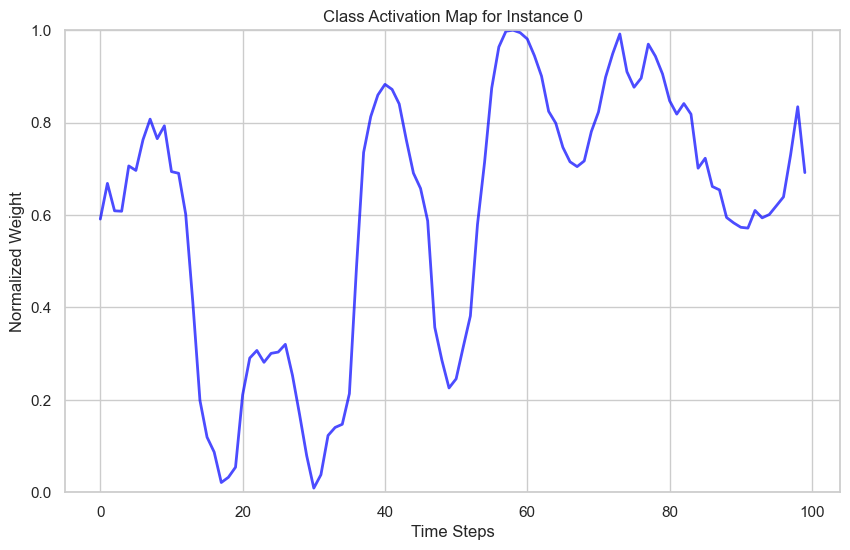

In [5]:
cam.visualize_cam(testing_weights, 0)

# Generate Counterfactuals

In [6]:
ce = CONFETTI(model, X_train, X_test, y_test, y_train, testing_weights)

/Users/raoni.lourenco/reps/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-06-06 14:22:07.348696: W tensorflow/c/c_api.cc:300] Operation '{name:'dense/Softmax' id:363 op device:{requested: '', assigned: ''} def:{{{node dense/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [7]:
import datetime
print(datetime.datetime.now())
ce_directory = f'./Solutions/{dataset}'

ce.counterfactual_generator(ce_directory, save_counterfactuals=True, optimization=True)
print(datetime.datetime.now())

2024-06-06 14:22:12.691937
2024-06-06 14:43:31.862790


In [ ]:
ce.naive_counterfactuals.head()

In [ ]:
ce.optimized_counterfactuals.head()

In [ ]:
ce.naive_counterfactuals.to_csv('naive_solutions.csv', index=False)

## Visualize One Counterfactual

### Naive Approach

In [ ]:
ce.visualize_counterfactuals(instance=35, optimized=False)

### Optimized Approach for Precision

In [ ]:
ce.visualize_counterfactuals(instance=35, optimized=True)

### Optimized Approach for Sparsity

In [ ]:
ce.visualize_counterfactuals(instance=35, optimized=True, precision=False)

## Get Quantitative Results 

In [ ]:
ce.naive_counterfactuals

In [ ]:
idx = ce.optimized_counterfactuals.groupby('Test Instance')['Sparsity'].idxmax()

# Use the indices to select the rows from the original DataFrame
max_sparsity_df = ce.optimized_counterfactuals.loc[idx]
max_sparsity_df

In [ ]:
idx = ce.optimized_counterfactuals.groupby('Test Instance')['Precision'].idxmax()

# Use the indices to select the rows from the original DataFrame
max_precision_df = ce.optimized_counterfactuals.loc[idx]
max_precision_df

In [3]:
X_train.shape

(40, 100, 6)

In [6]:
len(X_test[:1])

1